In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np
import csv
from scipy.signal import butter, filtfilt
import json

fs = 20.0
cutoff = 0.75

<ipython-input-3-00f0f1b7c04a>:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [43]:
def load_data(filepath):
       with open(filepath, 'r') as file, open("output_data.csv", 'w', newline='') as csvfile:
        # Prepare to collect all unique field names from the JSON data
        all_fieldnames = set()

        # First pass: Gather all keys across all JSON entries
        for line in file:
            timestamp, json_data = line.split(':', 1)
            data_dict = json.loads(json_data.strip())
            all_fieldnames.update(data_dict.keys())

        # Convert to a sorted list for consistent CSV header order
        all_fieldnames.add("timestamp")  # Add 'timestamp' explicitly
        all_fieldnames = sorted(all_fieldnames)
        writer = csv.DictWriter(csvfile, fieldnames=all_fieldnames)
        writer.writeheader()

        # Second pass: Write the data rows
        file.seek(0)  # Reset file pointer to the beginning
        for line in file:
            timestamp, json_data = line.split(':', 1)
            data_dict = json.loads(json_data.strip())

            # Add the extracted timestamp
            data_dict['timestamp'] = data_dict['epoch']

            # Convert latitude and longitude for human readability if present
            if 'lat' in data_dict:
                # data_dict['lat'] = data_dict['lat'] - 303863204
                data_dict['lat'] = convert_geo(data_dict['lat'])
            if 'lon' in data_dict:
                data_dict['lon'] = convert_geo(data_dict['lon'])

            # Write the row
            writer.writerow(data_dict)
        return all_fieldnames

def butter_lowpass_filter(dataFrame, data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Design the filter
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # Apply the filter
    filtered = filtfilt(b, a, dataFrame[data])
    return pd.Series(filtered, index= dataFrame.index)



def convert_geo(geo_int):
    geo_str = str(geo_int)
    if geo_int < 0:
        return -float(geo_str[:3] + '.' + geo_str[3:])
    return float(geo_str[:2] + '.' + geo_str[2:])

In [44]:
all_fieldnames = load_data("drive_day1.txt")
dataFrame = pd.read_csv("output_data.csv")

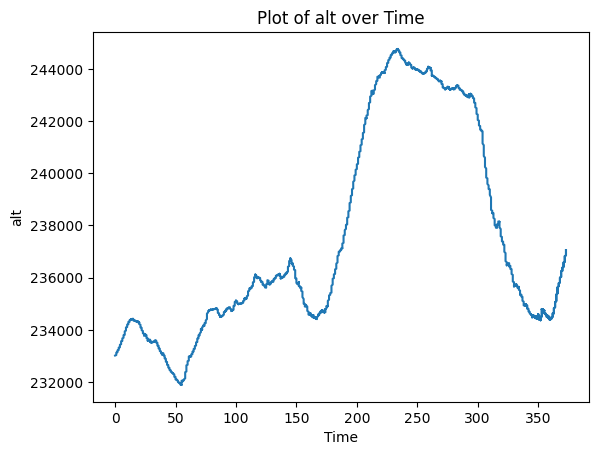

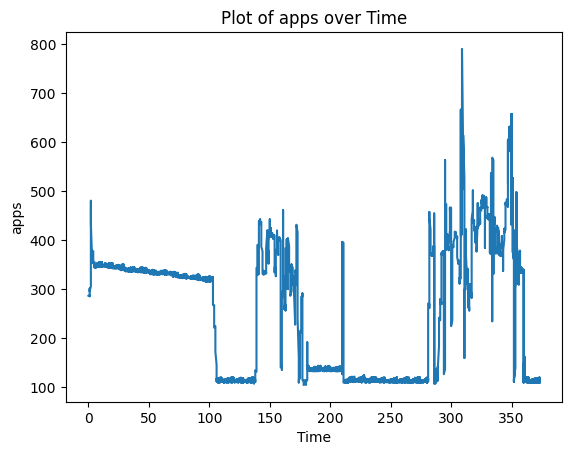

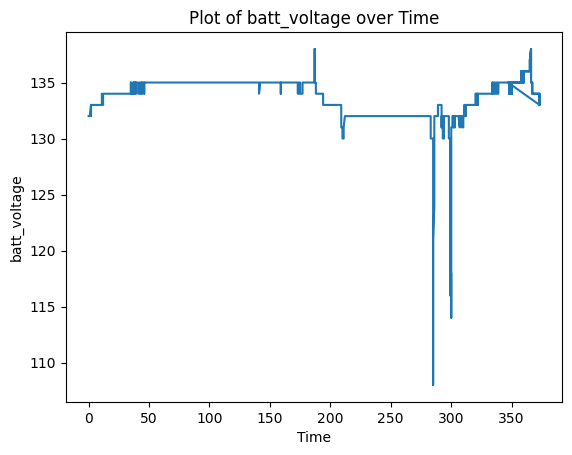

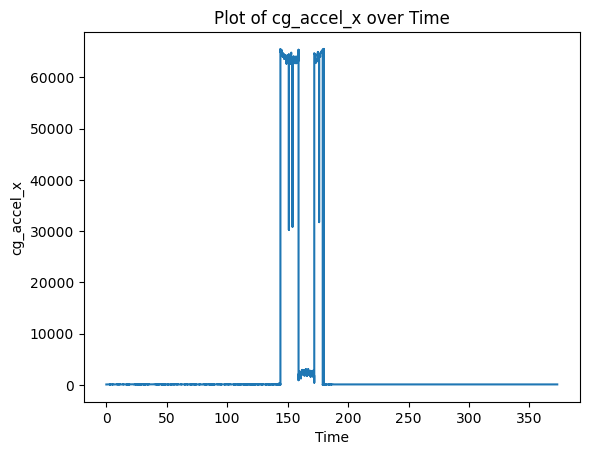

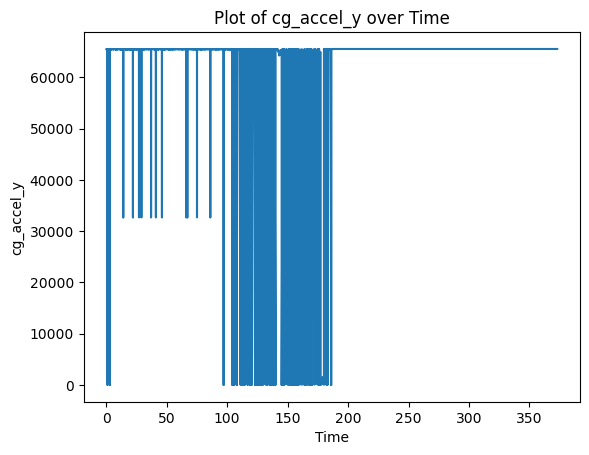

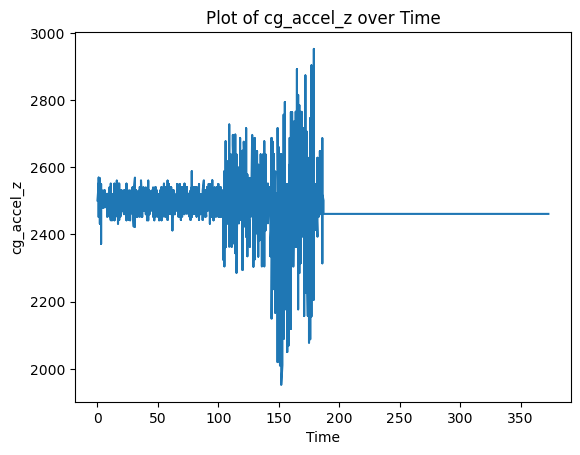

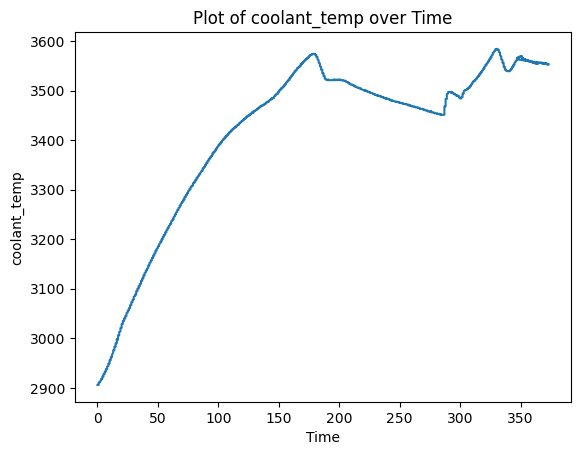

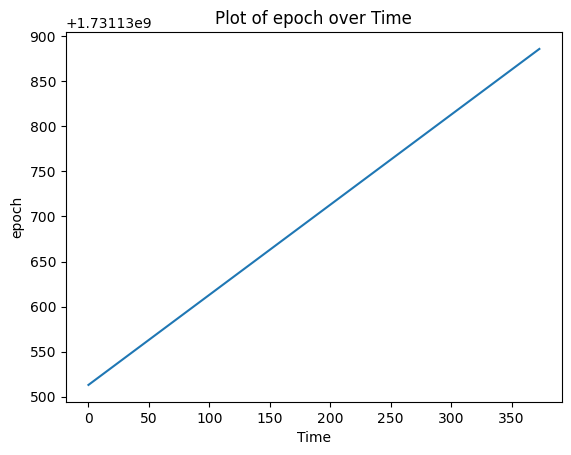

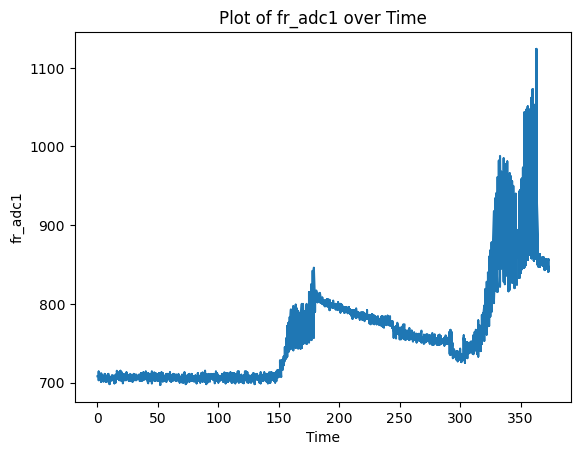

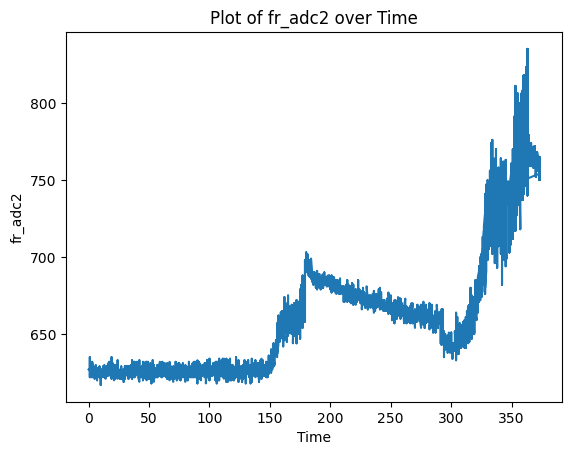

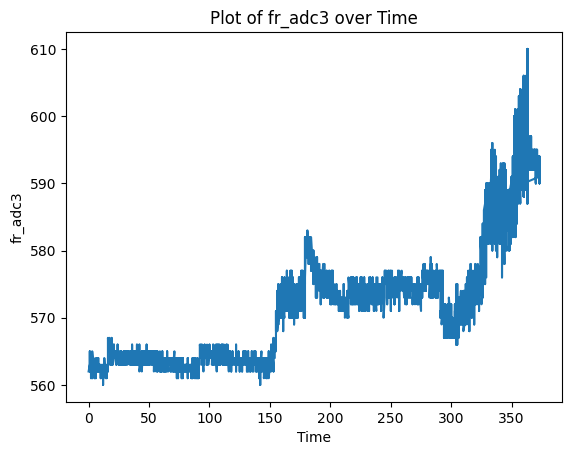

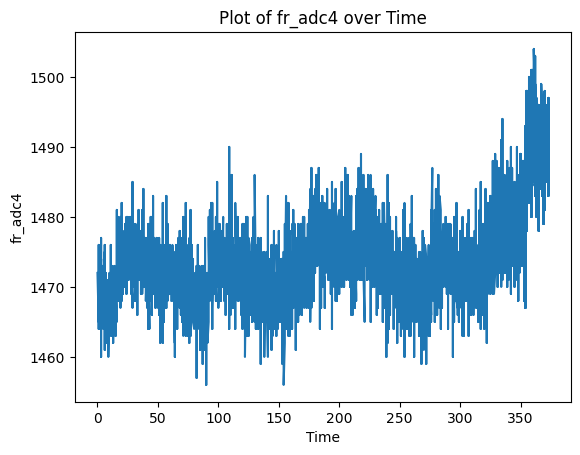

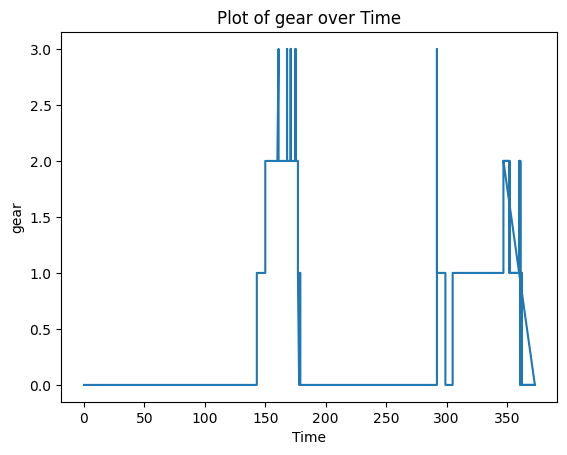

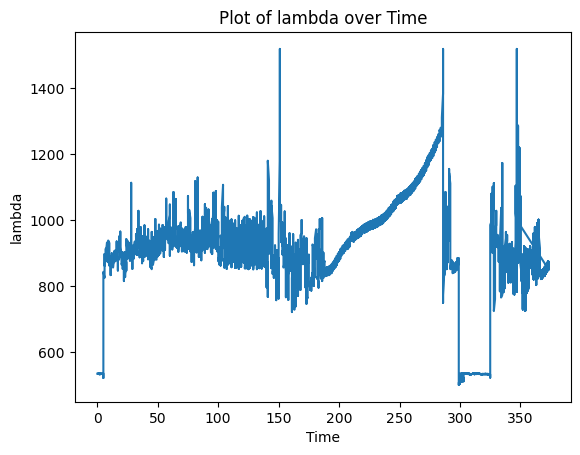

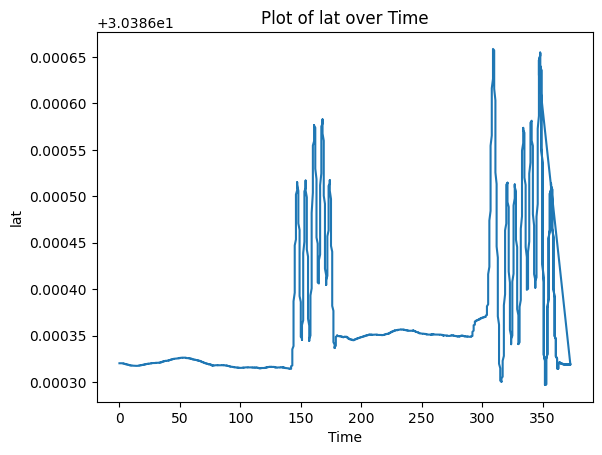

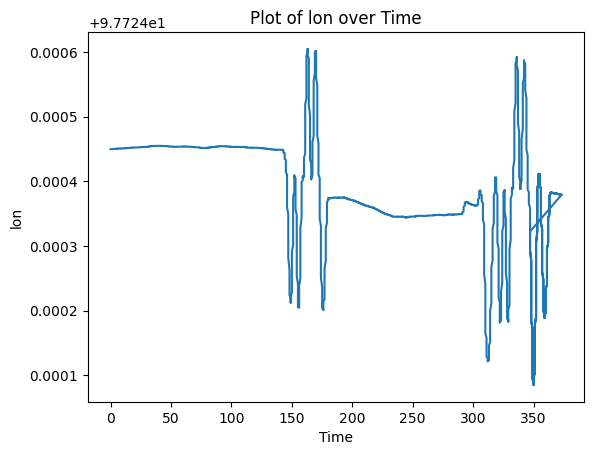

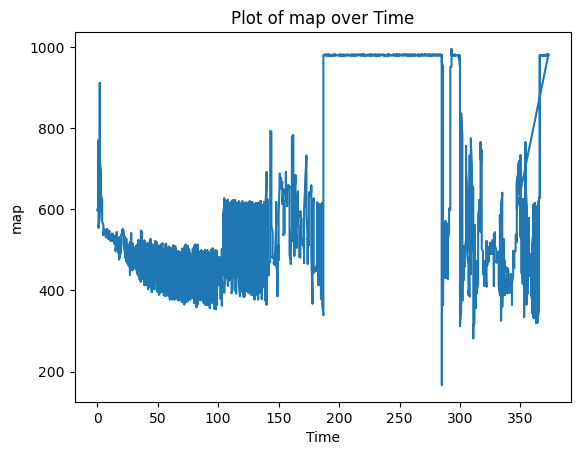

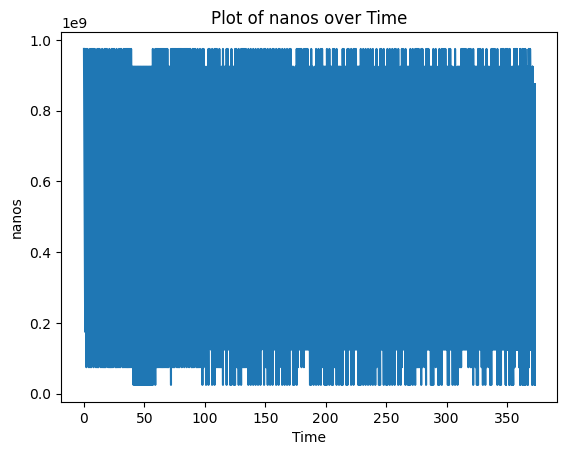

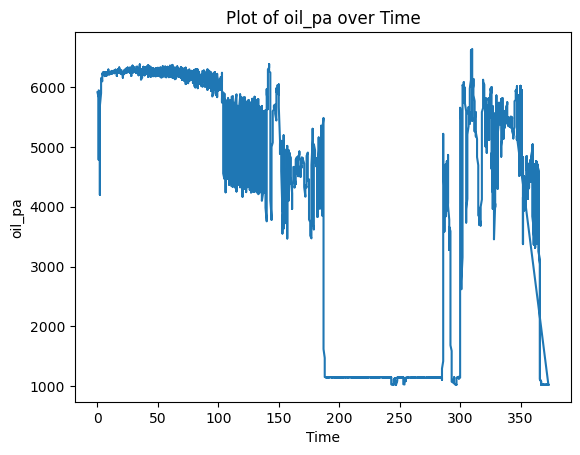

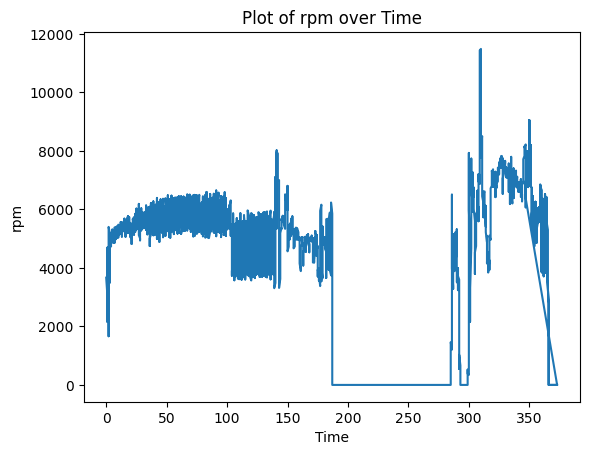

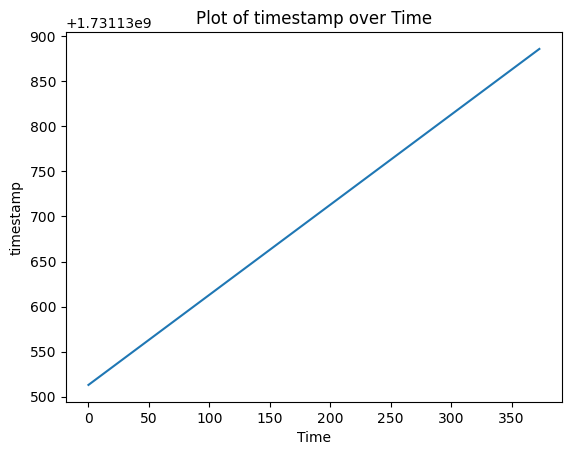

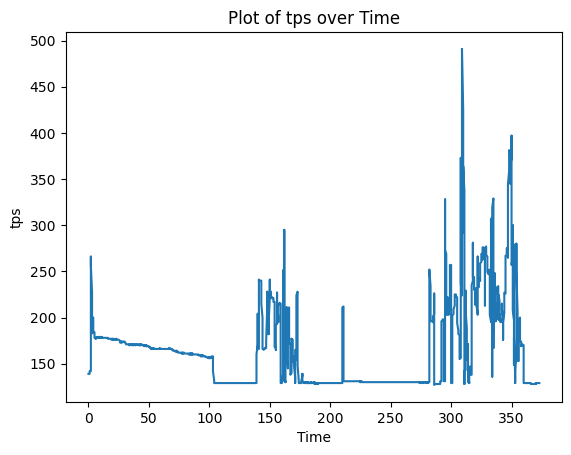

In [48]:
first_el = dataFrame['epoch'].iloc[0]
for names in all_fieldnames:
    dataFrame[names] = pd.to_numeric(dataFrame[names], errors='coerce')  # Ensure numeric
    dataFrame = dataFrame.dropna(subset=[names])  # Drop rows with NaN in the current column
    
    plt.plot(dataFrame['epoch'] - first_el, dataFrame[names])
    plt.xlabel("Time")
    plt.ylabel(names)
    plt.title(f"Plot of {names} over Time")
    plt.show()

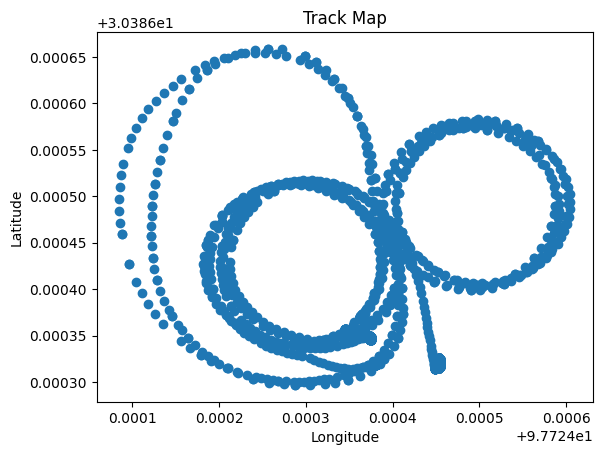

In [49]:
plt.scatter(dataFrame['lon'], y = dataFrame['lat'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Track Map')
plt.show()

In [51]:
dataFrame["lateral_accel"] = np.int16(dataFrame['cg_accel_x']) / 256.0 / 9.8
dataFrame["long_accel"] = np.int16(dataFrame['cg_accel_y']) / 256.0 / 9.8
dataFrame["yaw_accel"] = np.int16(dataFrame['cg_accel_z']) / 256.0 / 9.8
dataFrame['filtered_pressures_lateral'] = butter_lowpass_filter(dataFrame, "lateral_accel", cutoff, fs)
dataFrame['filtered_pressures_long'] = butter_lowpass_filter(dataFrame, "long_accel", cutoff, fs)
dataFrame['filtered_pressures_yaw'] = butter_lowpass_filter(dataFrame, "yaw_accel", cutoff, fs)
dataFrame.to_csv("output_data.csv", index=False)

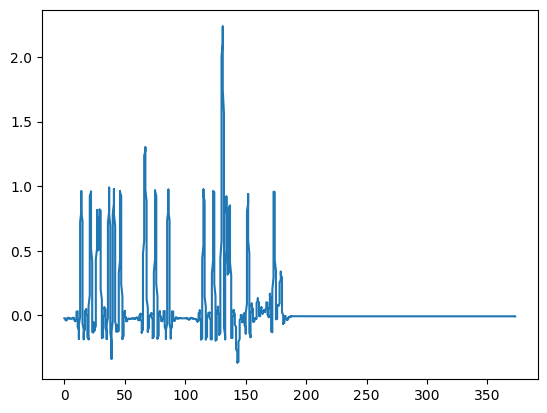

In [53]:
plt.plot(dataFrame['epoch'] - first_el,dataFrame['filtered_pressures_long'])
plt.show()

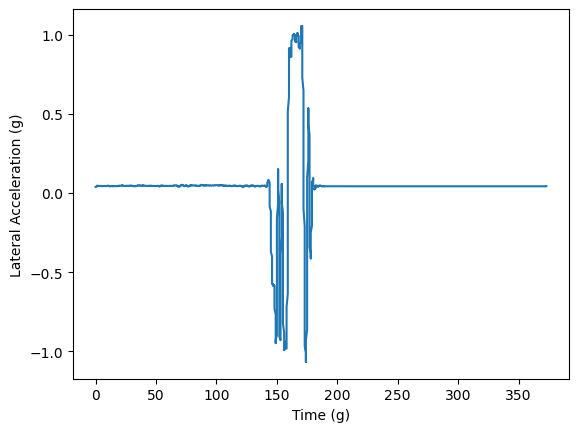

In [54]:
plt.plot(dataFrame['epoch'] - first_el,dataFrame['filtered_pressures_lateral'])
plt.xlabel('Time (g)')
plt.ylabel('Lateral Acceleration (g)')
plt.show()

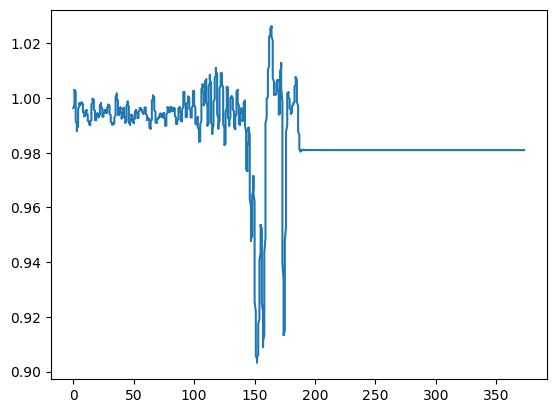

In [55]:
plt.plot(dataFrame['epoch'] - first_el,dataFrame['filtered_pressures_yaw'])
plt.show()